In [8]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

In [9]:
IMAGE_SIZE = (256, 256)
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 20

In [10]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'PotatoData',
    shuffle=True,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [11]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [12]:
len(dataset)

68

In [13]:
for image_batch, label_batch in dataset.take(2):
    print(image_batch.shape)
    print((label_batch.numpy()))

(32, 256, 256, 3)
[0 2 1 1 1 0 0 1 2 0 0 1 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 2 0 0 1 0]
(32, 256, 256, 3)
[1 0 2 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 1 1 0 0 1 0 0 1 1 2 1 1]


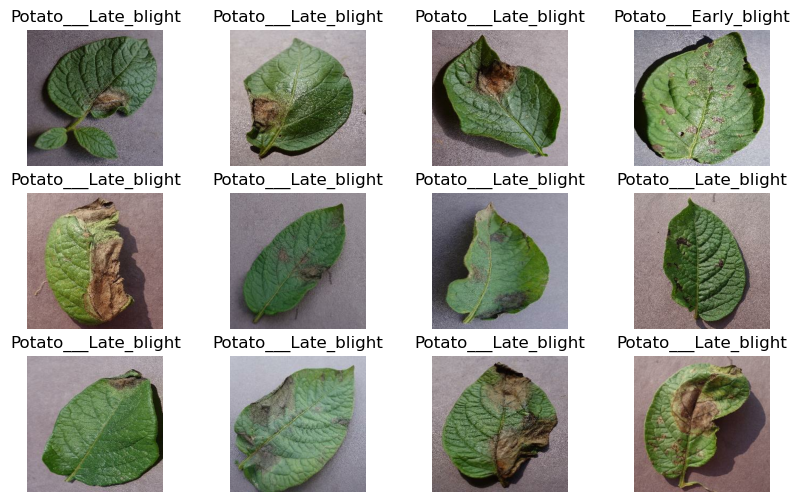

In [14]:
plt.figure(figsize=(10, 6))
for image_batch, label_batch in dataset.take(1):
    # it takes the first batch
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        first_image = image_batch[i]
        plt.imshow(first_image.numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

In [15]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [16]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [17]:
len(train_ds), len(val_ds), len(test_ds)

(54, 6, 8)

In [18]:
# Optimizing the data for faster training
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [19]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(256, 256),
    layers.Rescaling(1./255),
])

In [20]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.2),
])

## Building the Model


In [21]:
input_shape = (BATCH_SIZE, 256, 256, CHANNELS)  # different from the video
num_classes = 3
model = models.Sequential([

    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu',
                  input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes, activation='softmax'),
])

In [22]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [23]:
history = model.fit(train_ds, epochs=EPOCHS,
                    batch_size=BATCH_SIZE, verbose=1, validation_data=val_ds)

Epoch 1/20


54/54 [==============================] - 36s 638ms/step - loss: 0.8998 - accuracy: 0.5174 - val_loss: 0.7940 - val_accuracy: 0.5938
Epoch 2/20
54/54 [==============================] - 31s 570ms/step - loss: 0.5277 - accuracy: 0.7598 - val_loss: 0.6952 - val_accuracy: 0.6562
Epoch 3/20
54/54 [==============================] - 31s 579ms/step - loss: 0.3457 - accuracy: 0.8686 - val_loss: 0.1993 - val_accuracy: 0.9271
Epoch 4/20
54/54 [==============================] - 31s 573ms/step - loss: 0.2203 - accuracy: 0.9062 - val_loss: 0.2081 - val_accuracy: 0.9219
Epoch 5/20
54/54 [==============================] - 31s 578ms/step - loss: 0.1762 - accuracy: 0.9317 - val_loss: 0.1410 - val_accuracy: 0.9375
Epoch 6/20
54/54 [==============================] - 30s 559ms/step - loss: 0.1636 - accuracy: 0.9387 - val_loss: 0.5768 - val_accuracy: 0.8021
Epoch 7/20
54/54 [==============================] - 33s 612ms/step - loss: 0.1213 - accuracy: 0.9589 - val_loss: 0.4157 - val_accuracy: 0.8854
Epoch 8/20

In [24]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 2s 156ms/step - loss: 0.0474 - accuracy: 0.9922


In [25]:
scores

[0.04737836867570877, 0.9921875]

In [26]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [27]:
history.params

{'verbose': 1, 'epochs': 20, 'steps': 54}

In [28]:
# plotting this accuracy

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

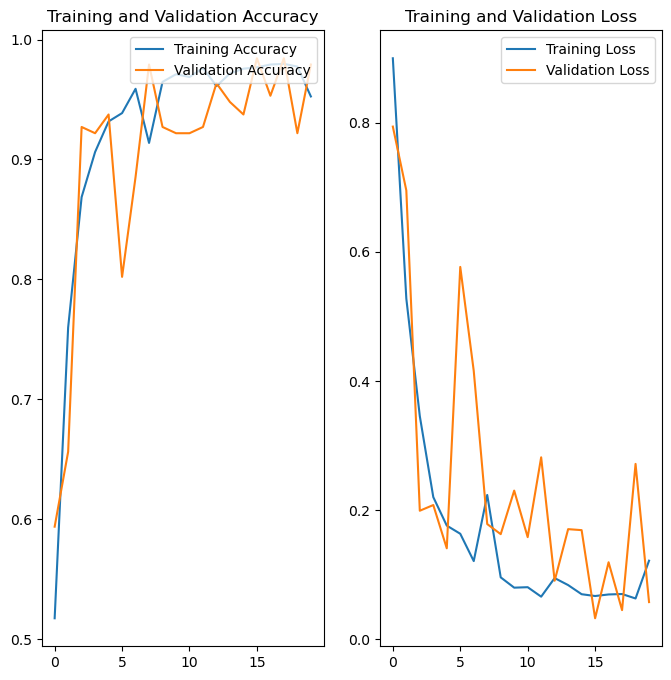

In [29]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

first image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 0s 233ms/step
predicted label: Potato___Early_blight


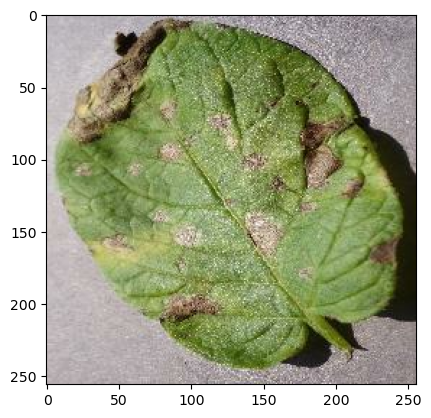

In [30]:
for image_batch, label_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = label_batch[0].numpy()
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:", class_names[first_label])
    batch_prediction = model.predict(image_batch)
    print("predicted label:", class_names[np.argmax(batch_prediction[0])])

In [31]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img.numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 23ms/step


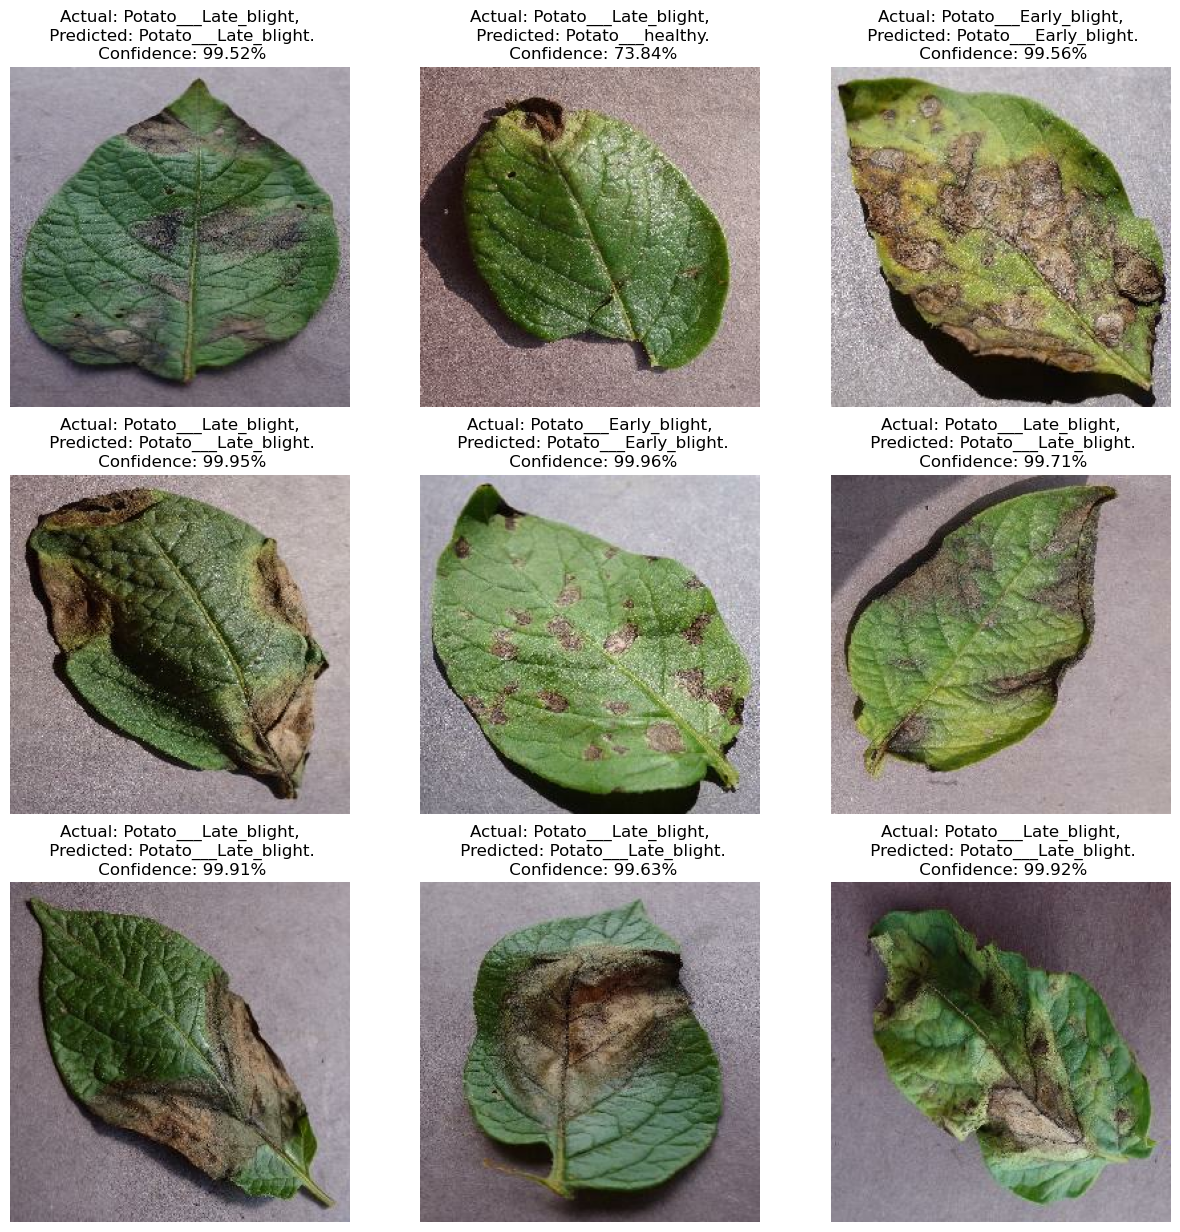

In [32]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i])
        actual_class = class_names[labels[i]]
        plt.title(
            f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")

# Confusion Matrix

In [41]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Predictions for the test set
y_true = []
y_pred = []
confidence_scores=[]

for images, labels in test_ds:
    y_true.extend(labels.numpy())
    predictions = model.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))
    #appending confidence scores as well
    batch_confidence_scores = np.max(predictions, axis=1)  # Confidence scores for each prediction in the batch
    confidence_scores.extend(batch_confidence_scores)
# Calculate confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)


1/1 [==============================] - 0s 171ms/step


In [42]:
#visualizing average confidence scores for correct and incorrect predictions
correct_confidence = [confidence_scores[i] for i in range(len(y_true)) if y_true[i] == y_pred[i]]
incorrect_confidence = [confidence_scores[i] for i in range(len(y_true)) if y_true[i] != y_pred[i]]

average_correct_confidence = np.mean(correct_confidence)
average_incorrect_confidence = np.mean(incorrect_confidence)

print(f"Average Confidence for Correct Predictions: {average_correct_confidence}")
print(f"Average Confidence for Incorrect Predictions: {average_incorrect_confidence}")


Average Confidence for Correct Predictions: 0.9687809944152832
Average Confidence for Incorrect Predictions: 0.7886309623718262


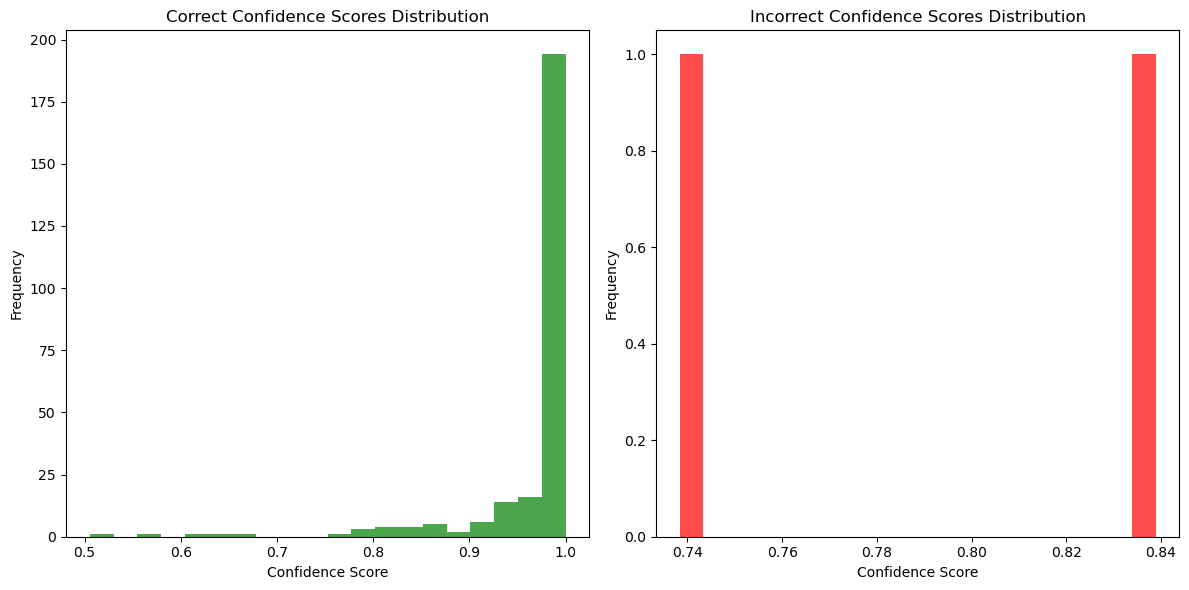

In [44]:
# Histogram for correct and incorrect predictions
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(correct_confidence, bins=20, color='green', alpha=0.7)
plt.title('Correct Confidence Scores Distribution')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(incorrect_confidence, bins=20, color='red', alpha=0.7)
plt.title('Incorrect Confidence Scores Distribution')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


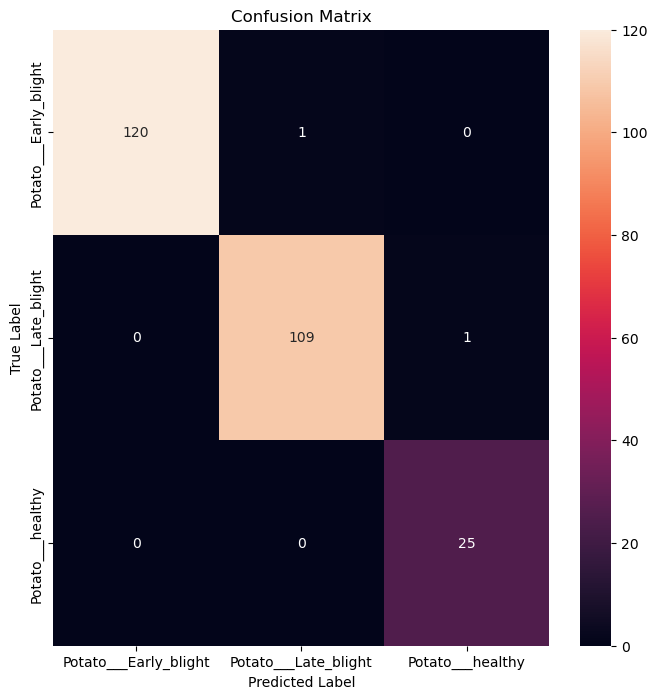

In [36]:
#confusion matrix with Seaborn heatmap
plt.figure(figsize=(8, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [39]:
model_version = 2
model.save(f"../models/model_{model_version}")

INFO:tensorflow:Assets written to: ../models/model_2/assets


INFO:tensorflow:Assets written to: ../models/model_2/assets


In [40]:
import os
os.listdir('../models/')

['model_2', 'model_1']

## The End
